In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader

In [73]:
class CustomDataset(Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.df.iloc[index].to_numpy()

In [74]:
data = pd.read_csv('encoded_data_without_session_id.csv', index_col='event_id')

c:\Users\ASUS\Anaconda3\envs\ml_env\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [75]:
df = data.drop(columns=['transaction_date', 'session_id'])

In [76]:
for col in df.columns:
    col_min = df[col].min()
    col_max = df[col].max()
    df[col] = (df[col] - col_min) / (col_max - col_min)

In [77]:
df.head()

,product_id,title_product_id,country_code_id,ip_address,auth_session_id,event_type_id_1,event_type_id_11,event_type_id_12,event_type_id_25,event_type_id_26,...,event_type_id_76,event_type_id_78,event_type_id_8,event_type_id_80,event_type_id_81,event_type_id_82,event_type_id_85,event_type_id_86,event_type_id_87,event_type_id_None
event_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.001066,1.000000,0.160310,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000005,0.027166,0.008181,0.001567,0.002923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000010,0.012108,0.130370,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000752,0.008166,0.023378,0.037306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000002,1.000000,0.103839,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
train = df[:3000000]
test = df[3000000:]

In [79]:
datasets = {
    'train': CustomDataset(train),
    'test': CustomDataset(test)
}

dataloaders = {
    'train': DataLoader(datasets['train'], 32),
    'test': DataLoader(datasets['test'], 32)
}

In [80]:
features_count = len(df.columns)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [81]:
model = nn.Sequential(
    nn.Linear(features_count, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 4),
    nn.ReLU(),
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, features_count)
)
_ = model.to(device)

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [85]:
losses = {'train': [], 'test': []}
epochs = 100
for ep in range(epochs):
    print("Episode:", ep)
    for phase in ('train', 'test'):
        with torch.set_grad_enabled(phase == 'train'):
            tot_loss = 0
            count = 0
            for row in tqdm(dataloaders[phase]):
                row = row.float().to(device)
                out = model(row)
                loss = criterion(out, row)
                tot_loss += loss.item()
                count += row.size(0)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            losses[phase].append(tot_loss / count)

Episode: 0


  0%|          | 0/93750 [00:00<?, ?it/s]

KeyboardInterrupt: 

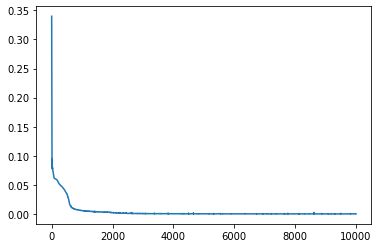

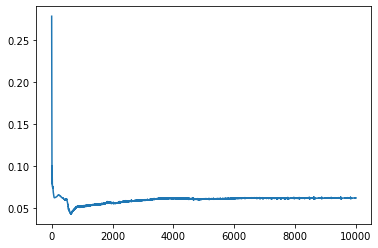

In [73]:
for phase in losses:
    plt.plot(range(len(losses[phase])), losses[phase])
    plt.show()

In [87]:
maes = []
with torch.set_grad_enabled(phase == 'train'):
    tot_loss = 0
    count = 0
    for row in tqdm(dataloaders[phase]):
        row = row.float().to(device)
        out = model(row)
        mae = np.abs(out.detach().numpy() - row.detach().numpy()).sum(axis=1)
        maes.append(mae)

  0%|          | 0/93750 [00:00<?, ?it/s]

In [89]:
mae = np.concatenate(maes)

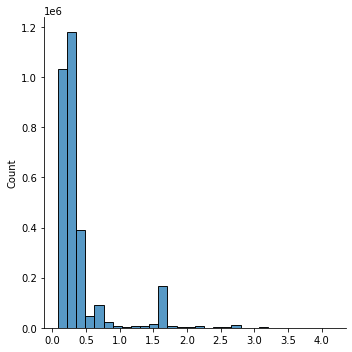

In [90]:
sns.displot(mae, bins=30)

c:\Users\ASUS\Anaconda3\envs\ml_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

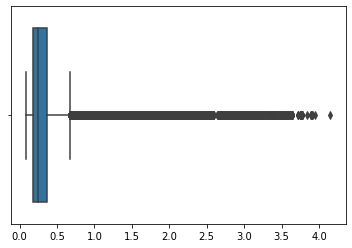

In [91]:
sns.boxplot(mae)

In [92]:
threshold = np.mean(mae) + 2.5 * np.std(mae)
threshold

1.4406712502241135

In [95]:
pred = abs(mae - np.mean(mae)) > threshold

In [94]:
mae[abs(mae - np.mean(mae)) > threshold]

array([2.451106 , 1.9898028, 1.8603601, ..., 2.4591281, 2.198297 ,
       2.4652963], dtype=float32)

In [97]:
pred.shape

(3000000,)

In [96]:
submission_df = pd.DataFrame(data={
    'event_id': df.index,
    'prediction': pred
})

ValueError: arrays must all be same length